In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
# Prepare data file location and load the dataset
data_file_location = "..\\data\\raw\\"
data_file_name = "6758_Stock"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_location + data_file_name + "." + data_file_ext)

In [3]:
# Check dataset shape
data.shape

(14455, 9)

In [4]:
N = 10000  # 设定你想要保留的训练样本数量
data = data.iloc[-N:]  # 选取最后 N 行

In [5]:
# Check dataset head
data.head()

,Unnamed: 0,date,open,high,low,close,volume,average,barCount
4455,4455,2023-10-23 12:35:00+09:00,2492.0,2496.0,2491.0,2495.0,166000.0,2492.98,65
4456,4456,2023-10-23 12:40:00+09:00,2496.0,2496.0,2495.0,2495.0,76500.0,2495.24,33
4457,4457,2023-10-23 12:45:00+09:00,2495.0,2495.0,2493.0,2494.0,59000.0,2493.88,38
4458,4458,2023-10-23 12:50:00+09:00,2494.0,2495.0,2493.0,2493.0,36000.0,2494.06,34
4459,4459,2023-10-23 12:55:00+09:00,2493.0,2493.0,2491.0,2493.0,56000.0,2492.26,40


In [6]:
# Check data types
data.dtypes

Unnamed: 0      int64
date           object
open          float64
high          float64
low           float64
close         float64
volume        float64
average       float64
barCount        int64
dtype: object

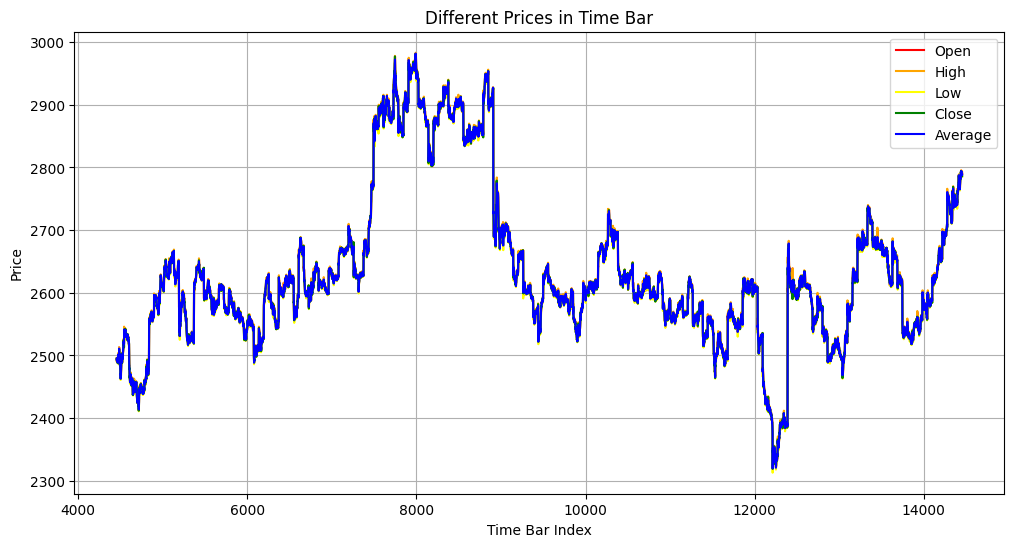

In [7]:
# 画出 Time Bar 级别的不同价格曲线
plt.figure(figsize=(12, 6))
time_bar_index = data.index

plt.plot(time_bar_index, data['open'], label='Open', color='red')
plt.plot(time_bar_index, data['high'], label='High', color='orange')
plt.plot(time_bar_index, data['low'], label='Low', color='yellow')
plt.plot(time_bar_index, data['close'], label='Close', color='green')
plt.plot(time_bar_index, data['average'], label='Average', color='blue')

plt.xlabel("Time Bar Index")
plt.ylabel("Price")
plt.title("Different Prices in Time Bar")
plt.legend()
plt.grid()
plt.show()

#### Select Independent Features

The objective of this analysis is to implement a multi-variant prediction, taking into account possible impact of several independent features such as the Open price, Close price and Volume on future stock price performance.

Therefore, in this analysis, we will incorporate all the available variables: 
- Opening price
- Highest price
- Lowest price
- Closing price
- Trading volume

These features will be utilized to forecast the future opening price.

In [8]:
# Define selected features and target attribute
features = ["open", "high", "low",	"close", "volume"]
target = "open"

In [9]:
df = data[features]
df

,open,high,low,close,volume
4455,2492.0,2496.0,2491.0,2495.0,166000.0
4456,2496.0,2496.0,2495.0,2495.0,76500.0
4457,2495.0,2495.0,2493.0,2494.0,59000.0
4458,2494.0,2495.0,2493.0,2493.0,36000.0
4459,2493.0,2493.0,2491.0,2493.0,56000.0
...,...,...,...,...,...
14450,2788.0,2789.0,2786.0,2787.0,89500.0
14451,2786.0,2791.0,2786.0,2790.0,226000.0
14452,2791.0,2791.0,2788.0,2789.0,178000.0
14453,2789.0,2791.0,2788.0,2790.0,246000.0


#### Create Train, Validation, and Test Datasets

In [10]:
len_train = int(0.6 * df.shape[0])  # 60% 用作训练集
len_val = int(0.3 * df.shape[0])   # 30% 用作验证集
len_test = df.shape[0] - len_train - len_val  # 剩下的 10% 用作测试集

# 分割训练集
df_train = df[:len_train]

# 分割验证集
df_validate = df[len_train:len_train+len_val]

# 分割测试集
df_test = df[len_train+len_val:]

# 打印每个数据集的形状，确保分割正确
print(f"Train Set Shape: {df_train.shape}")
print(f"Validation Set Shape: {df_validate.shape}")
print(f"Test Set Shape: {df_test.shape}")

Train Set Shape: (6000, 5)
Validation Set Shape: (3000, 5)
Test Set Shape: (1000, 5)


In [11]:
df_train

,open,high,low,close,volume
4455,2492.0,2496.0,2491.0,2495.0,166000.0
4456,2496.0,2496.0,2495.0,2495.0,76500.0
4457,2495.0,2495.0,2493.0,2494.0,59000.0
4458,2494.0,2495.0,2493.0,2493.0,36000.0
4459,2493.0,2493.0,2491.0,2493.0,56000.0
...,...,...,...,...,...
10450,2626.0,2629.0,2626.0,2627.0,106000.0
10451,2627.0,2629.0,2625.0,2628.0,95000.0
10452,2627.0,2627.0,2622.0,2622.0,109000.0
10453,2623.0,2626.0,2621.0,2626.0,129000.0


In [12]:
# Extract dates from each dataset
df_train_index = df_train.index
df_validate_index = df_validate.index
df_test_index = df_test.index

In [13]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(df_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(df_validate)
data_test_scaled = sc.transform(df_test)

In [14]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [15]:
# data_train_scaled = df_train.values
# data_validate_scaled = df_validate.values
# data_test_scaled = df_test.values

In [16]:
# Define the sequence size
sequence_size = 30

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [17]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [18]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (10000, 5)

 Data Train Scaled: (6000, 5)
> Data Train X: (5970, 30, 5)
> Data Train y: (5970,)

 Data Validate Scaled: (3000, 5)
> Data Validate X: (3000, 30, 5)
> Data Validate y: (3000,)

 Data Test Scaled: (1000, 5)
> Data Test X: (1000, 30, 5)
> Data Test y: (1000,)


#### Building LSTM Model

In [19]:
# Initializing the model
regressor = Sequential()

# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Add LSTM layer and dropout regularization layer
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(rate = 0.2))

regressor.add(LSTM(units = 1))
regressor.add(Dropout(rate = 0.2))

# regressor.add(LSTM(units = 100))
# regressor.add(Dropout(rate = 0.2))

# # Add forth LSTM layer and dropout regularization layer
# regressor.add(LSTM(units = 100))
# regressor.add(Dropout(rate = 0.2))

# Add last dense layer/output layer
regressor.add(Dense(units = 1))

# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

#### Training Model

EarlyStopping 会在验证集损失停止改善时停止训练，并且可以通过 restore_best_weights=True 恢复最好的模型权重（即训练过程中验证集损失最小的权重）。
ModelCheckpoint 会保存验证集损失最小的模型，帮助你在训练结束后获得最佳的模型权重。

In [20]:
# # Define EarlyStopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',         # Monitor the validation loss
#     patience=10,                # Stop after 10 epochs with no improvement
#     restore_best_weights=True,  # Restore the best weights from the training process
#     verbose=1
# )

In [21]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "..//models//"
model_name = "sony_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name, 
    monitor="val_loss",             # Monitor validation loss
    save_best_only=True,            # Save only the best model based on validation loss
    mode="min",                     # We want to minimize validation loss
    verbose=0)

In [22]:
# Training the model with both callbacks
history = regressor.fit(
    x = X_train, 
    y = y_train, 
    validation_data=(X_validate, y_validate), 
    epochs=200, 
    batch_size=64, 
    callbacks=[best_model_checkpoint_callback]
    # callbacks=[early_stopping, best_model_checkpoint_callback]
)

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5580 - val_loss: 0.1280
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2863 - val_loss: 0.0597
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1747 - val_loss: 0.0386
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1282 - val_loss: 0.0367
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0984 - val_loss: 0.0416
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0828 - val_loss: 0.0469
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0767 - val_loss: 0.0506
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0705 - val_loss: 0.0525
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0685 - val_loss: 0.0529
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0660 - val_loss: 0.0524
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0627 - val_loss: 0.0514
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

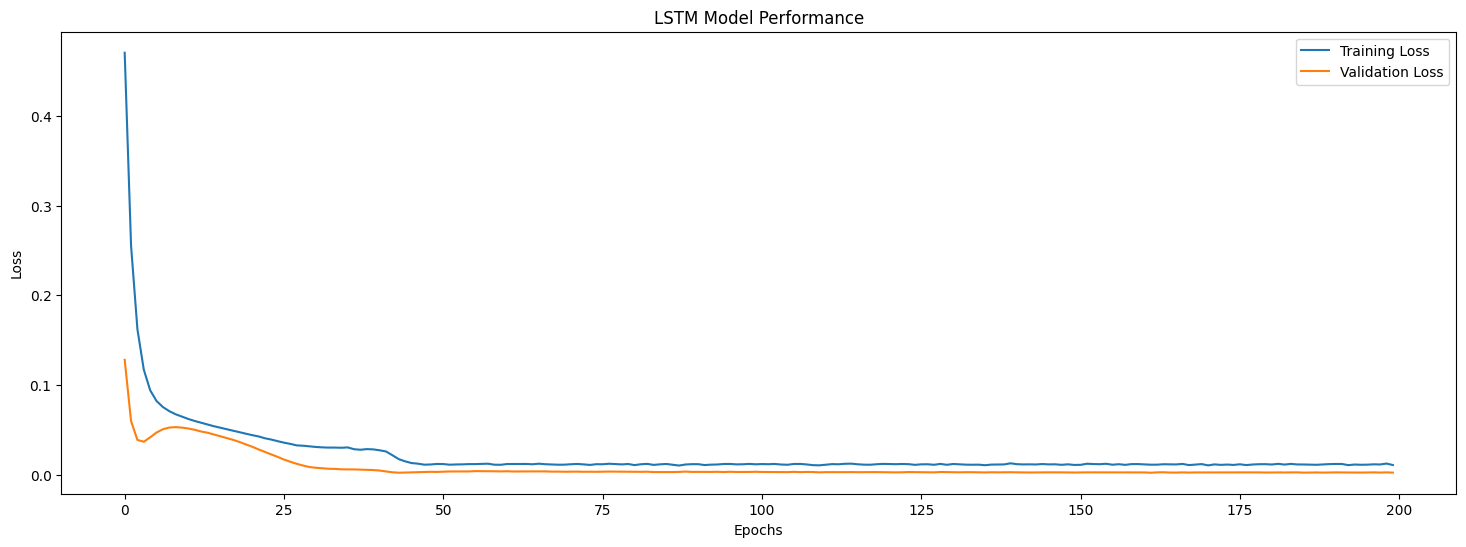

In [23]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
# Prepare model location and name
model_location = "..//models//"
model_name = "sony_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

In [25]:
# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 4))), axis=1))[:,0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 4))), axis=1))[:,0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 4))), axis=1))[:,0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 4))), axis=1))[:,0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 4))), axis=1))[:,0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 4))), axis=1))[:,0]

#### Display Predictions

In [27]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

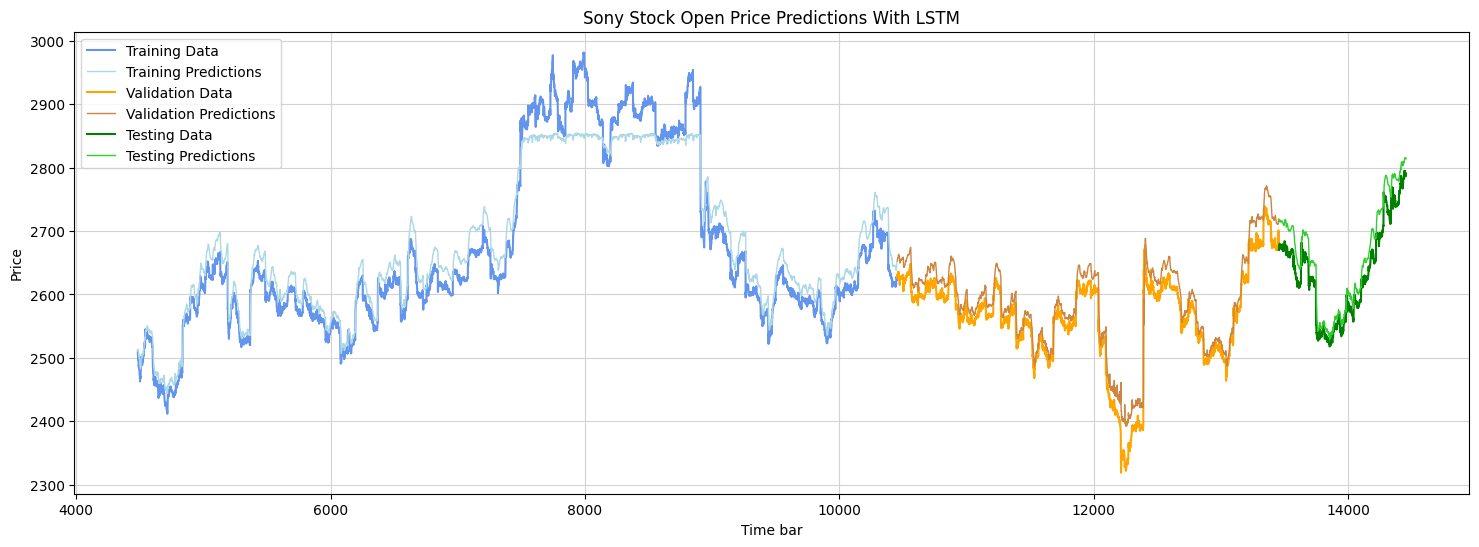

In [28]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(df_train_index[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(df_train_index[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(df_validate_index, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(df_validate_index, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(df_test_index, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(df_test_index, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Sony Stock Open Price Predictions With LSTM")
plt.xlabel("Time bar")
plt.ylabel("Price")
plt.legend()
plt.grid(color="lightgray")

Based on this expanded overview, the model appears to perform very well throughout the observed period, with the predicted trend tends to align closely with actual stock performance across the three training, validation, and testing periods.

To better assess the model's predictions during the validation and testing periods, let's inspect a zoomed-in version of this chart covering the most recent samples.

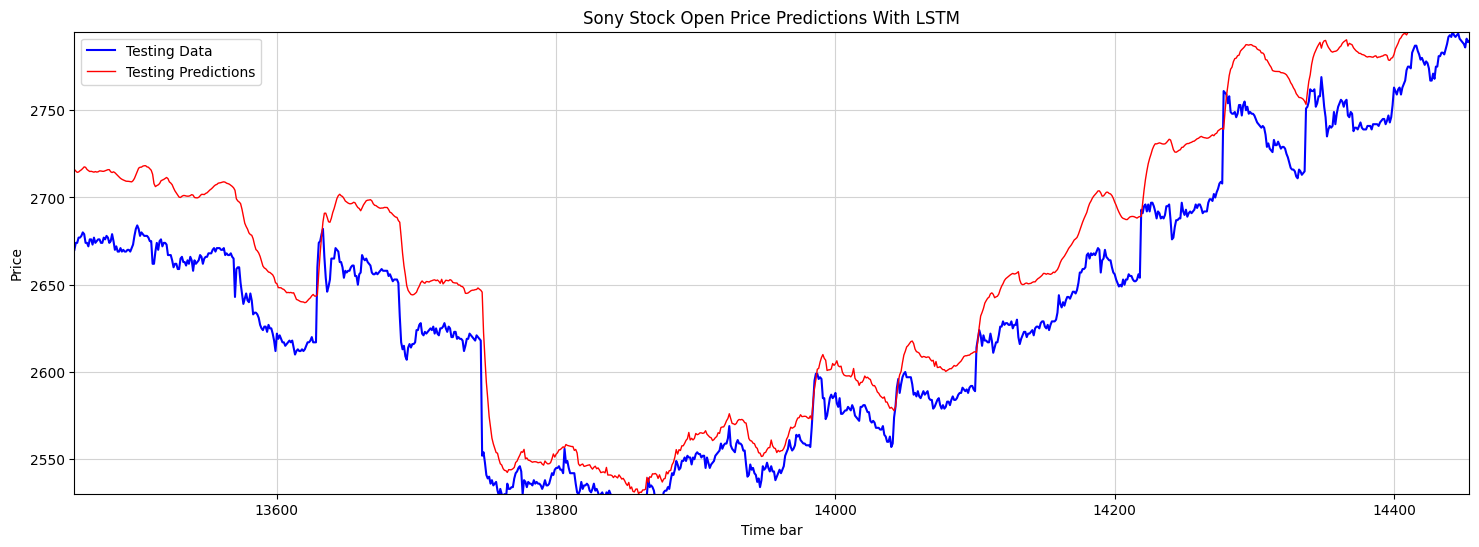

In [29]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))

# Plot test data and predictions
plt.plot(df_test_index, y_test_inv, label="Testing Data", color='blue')
plt.plot(df_test_index, y_test_predict_inv, label="Testing Predictions", linewidth=1, color='red')

# Set title and labels
plt.title("Sony Stock Open Price Predictions With LSTM")
plt.xlabel("Time bar")
plt.ylabel("Price")
plt.legend()
plt.grid(color="lightgray")

# Zoom in on the test section (optional)
# Assuming df_test_index is the range you want to zoom in on
plt.xlim(df_test_index[0], df_test_index[-1])  # Set x-axis limits to the test period
# Optionally adjust the y-axis to focus on the test data (you can modify these values to fit your data)
plt.ylim(min(y_test_predict_inv), max(y_test_inv))  # Adjust the y-axis to focus on test data range

plt.show()